In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
tf = torchvision.transforms.ToTensor()
from omegaconf import OmegaConf
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL

from taming.models.vqgan import EMAVQ

def imshow(img, cmap='gray', axis=True):
  axis = 'on' if axis else 'off'
  plt.imshow(img, cmap=cmap)
  plt.axis(axis)
  plt.show()

### Load Model

In [5]:
fit_model_name = "sqocremavq_16_240_gray_fit"
unfit_model_name = "sqocremavq_16_240_gray_unfit"


In [6]:
fit_config_path = list((Path("logs")/ fit_model_name).rglob("*project.yaml"))[0]
fit_config = OmegaConf.load(fit_config_path)
unfit_config_path = list((Path("logs")/ unfit_model_name).rglob("*project.yaml"))[0]
unfit_config = OmegaConf.load(unfit_config_path)

In [5]:
# print(yaml.dump(OmegaConf.to_container(config)))

In [7]:
fit_model = EMAVQ(**fit_config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/sake/.local/share/virtualenvs/ocr-vqgan-latent-score-Y8UW0XJ0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sake/.local/share/virtualenvs/ocr-vqgan-latent-score-Y8UW0XJ0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


/home/sake/.local/share/virtualenvs/ocr-vqgan-latent-score-Y8UW0XJ0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading craft model from taming/modules/autoencoder/ocr_perceptual/craft_mlt_25k.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [8]:
ckpt_path = list((Path("logs")/ fit_model_name).rglob("*.ckpt"))[0]
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = fit_model.load_state_dict(sd, strict=False)
fit_model.cuda().eval()
torch.set_grad_enabled(False)

In [9]:
unfit_model = EMAVQ(**unfit_config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/sake/.local/share/virtualenvs/ocr-vqgan-latent-score-Y8UW0XJ0/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sake/.local/share/virtualenvs/ocr-vqgan-latent-score-Y8UW0XJ0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


/home/sake/.local/share/virtualenvs/ocr-vqgan-latent-score-Y8UW0XJ0/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading craft model from taming/modules/autoencoder/ocr_perceptual/craft_mlt_25k.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [10]:
ckpt_path = list((Path("logs")/ unfit_model_name).rglob("*.ckpt"))[0]
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = unfit_model.load_state_dict(sd, strict=False)
unfit_model.cuda().eval()
torch.set_grad_enabled(False)

### Load Image

In [11]:
img_path = Path("/home/sake/userdata/olimpic_dataset/grandstaff-lmx/beethoven/piano-sonatas/sonata01-1/original_m-0-5.jpg")

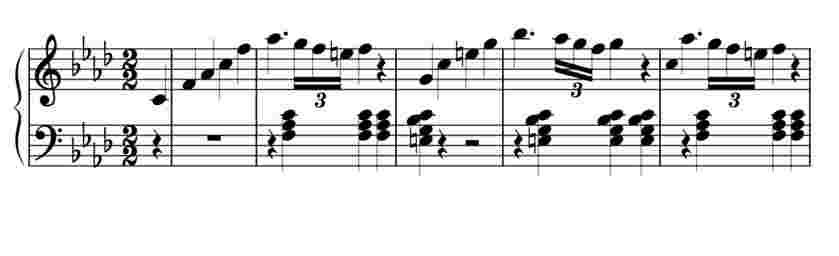

In [12]:
PIL.Image.open(img_path)

In [102]:
img = PIL.Image.open(img_path).convert("L")
print(img.height, img.width)
height = 144
img = img.resize((img.width * height // img.height, height))
img = tf(img)
img.shape

256 839


torch.Size([1, 144, 471])

### Encode Image

In [103]:
fit_quant, fit_emb_loss, fit_info = fit_model.encode(img.unsqueeze(0).cuda())

In [104]:
fit_quant.shape, fit_emb_loss, fit_info[2].shape

(torch.Size([1, 256, 9, 29]),
 tensor(0.0075, device='cuda:0'),
 torch.Size([261]))

In [105]:
fit_info[2].view(fit_quant.shape[0], -1).shape

torch.Size([1, 261])

In [106]:
fit_info[2].view(fit_quant.shape[0],fit_quant.shape[-2],fit_quant.shape[-1]).shape

torch.Size([1, 9, 29])

In [107]:
fit_info[2].view(fit_quant.shape[0],fit_quant.shape[-2],fit_quant.shape[-1])

tensor([[[   54,  1134,  1078,  1029,  1078,  1121,   487,  1024,   910,  1344,
            931,    79,   294,  1082,   487,  1024,   829,   258,  1246,   453,
             18,   985,  1015,   212,    80,   813,   797,   934,   297],
         [  238,  1156,  1497,  1555,  1283,  1397,  1243,  1388,  1522,  1036,
            642,   854,   643,  1498,  1293,  1244,   804,   233,    26,  1114,
            570,   499,  1319,  1237,   675,   717,   673,  1102,  1066],
         [ 1237,   275,  1537,  1061,   499,  1388,   854,   456,   901,  1636,
            270,    91,  1183,  1043,  1195,   621,  1006,  1040,  1534,  1063,
            717,  1653,  1342,   628,  1218,   854,  1177,  1230,  1208],
         [ 1166,   753,  1189,  1046,   383,   892,   319,  1293,  1265,  1457,
           1148,   407,   331,  1413,  1211,  1097,  1082,  1672,  1284,   942,
           1203,  1283,  1161,   988,  1187,  1391,  1002,  1266,  1288],
         [ 1003,   842,  1283,  1629,  1239,    70,  1619,  1509

In [108]:
unfit_quant, unfit_emb_loss, unfit_info = unfit_model.encode(img.unsqueeze(0).cuda())

### Decode VQ codes

In [109]:
fit_decoded = fit_model.decode_code(fit_info[2].view(fit_quant.shape[0],fit_quant.shape[-2],fit_quant.shape[-1]))

In [110]:
fit_decoded.shape

torch.Size([1, 1, 144, 464])

In [111]:
unfit_decoded = unfit_model.decode_code(unfit_info[2].view(unfit_quant.shape[0],unfit_quant.shape[-2],unfit_quant.shape[-1]))

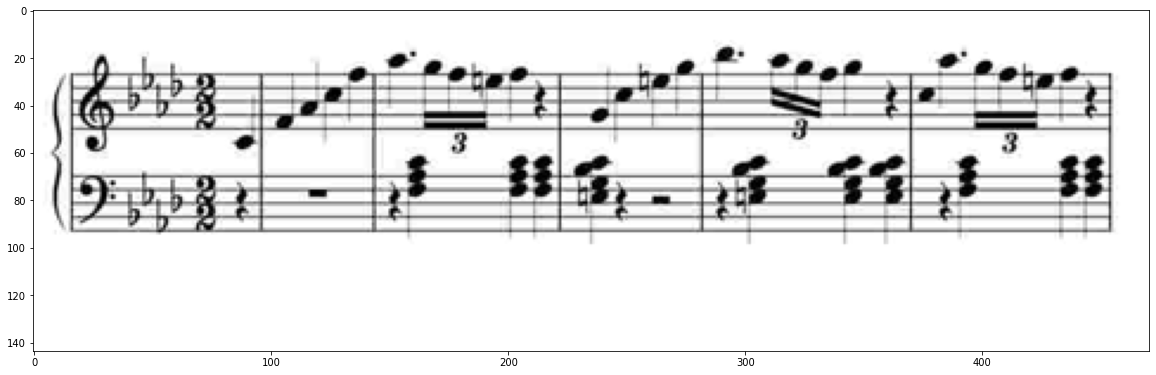

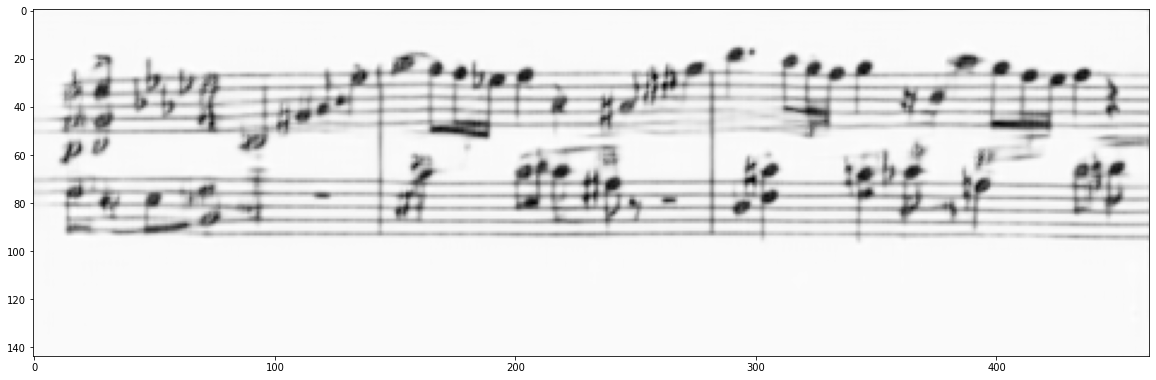

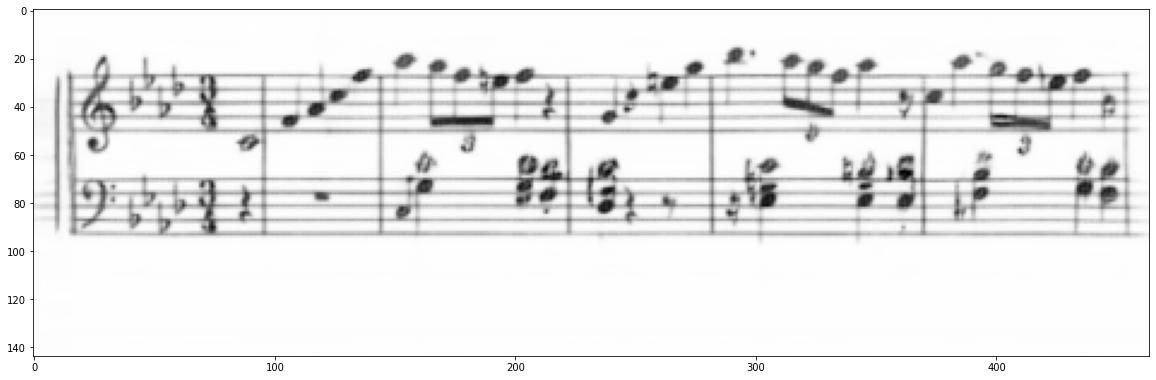

In [112]:
plt.figure(figsize=(20,10), dpi=72)
imshow(img.squeeze())
plt.figure(figsize=(20,10), dpi=72)
imshow(fit_decoded.squeeze().cpu())
plt.figure(figsize=(20,10), dpi=72)
imshow(unfit_decoded.squeeze().cpu())

### LSAMT Debug output decode test

In [ ]:
loaded = torch.load("/home/sake/userdata/sake/latent-score-amt/wandb/debug/2024-09-26-00-23-07:string_quartet_flattened_240_gray_debug:sqocremavq_fit:dim-768:nLayers-2_4:dropout-0.1:batchSize-8:lrDecay-0.8/files/valid_out/haydn:ftC5Ht6k1dM:0000:sqocremavq_fit:0:top_p_1.0_1.0:0.pt")
loaded.shape

In [10]:
loaded = loaded[:,1:-1]
loaded = loaded[...,:loaded.shape[-1] // 15 * 15]
loaded = loaded.unflatten(-1, [-1,15]).transpose(-2,-1)
loaded.shape

torch.Size([1, 15, 49])

In [11]:
decoded = fit_model.decode_code(loaded)

In [12]:
decoded.shape

torch.Size([1, 1, 240, 784])

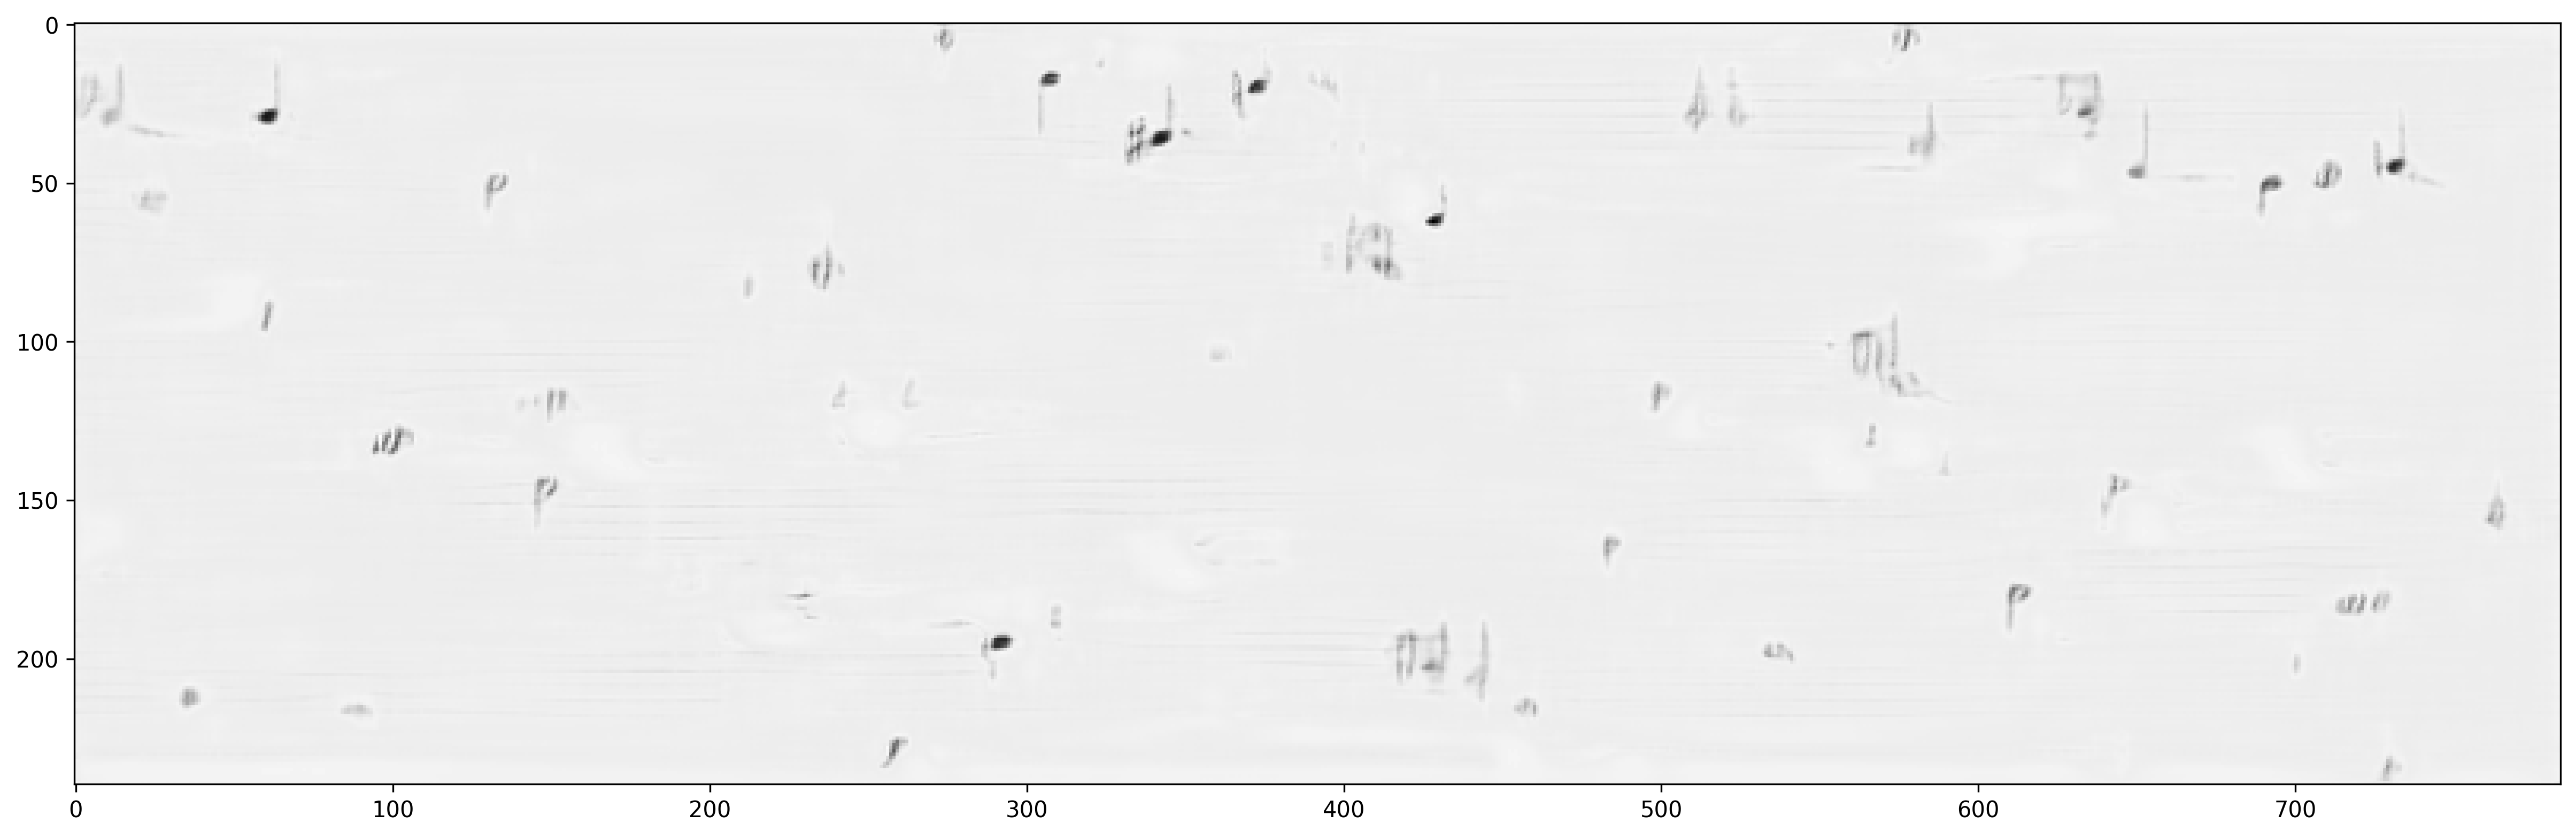

In [14]:
plt.figure(figsize=(20,10), dpi=72)
imshow(decoded.squeeze().cpu())

In [ ]:
import cv2
cv2.imwrite("test.png", decoded.squeeze().cpu().numpy() * 255)

### TEST CODE

In [56]:
model_name = "sqocremavq_240_gray"

In [57]:
image_path_list = list(Path("/home/sake/userdata/latent_score_dataset/string_quartet/segments").rglob("*/*/images/flattened_resampled/240_gray/*.png"))

In [58]:
image_path_list[0]

PosixPath('/home/sake/userdata/latent_score_dataset/string_quartet/segments/robert_schumann/jldDh_3fV8w/images/flattened_resampled/240_gray/jldDh_3fV8w:0022:19084.png')

In [59]:
image_path_list[0].parent.parent.parent.parent / "image_tokens" / image_path_list[0].parent.parent.name / image_path_list[0].parent.name / model_name / image_path_list[0].name  

PosixPath('/home/sake/userdata/latent_score_dataset/string_quartet/segments/robert_schumann/jldDh_3fV8w/image_tokens/flattened_resampled/240_gray/sqocremavq_240_gray/jldDh_3fV8w:0022:19084.png')

In [62]:
decoded = model.decode_code(torch.load("/home/sake/userdata/latent_score_dataset/string_quartet/segments/robert_schumann/jldDh_3fV8w/image_tokens/flattened_resampled/240_gray/sqocremavq_240_gray/jldDh_3fV8w:0022:19084.pt"))

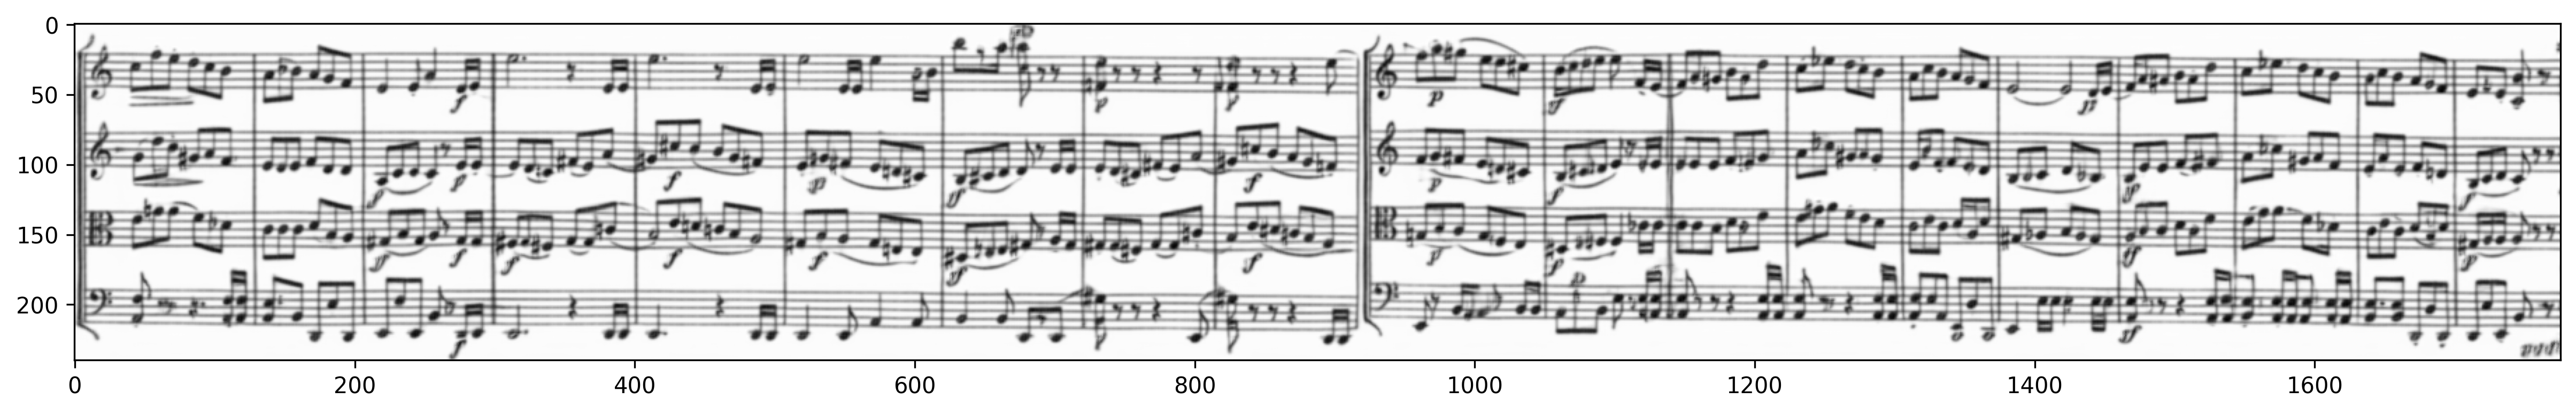

In [63]:
plt.figure(figsize=(20,10), dpi=72)
imshow(decoded.squeeze().cpu())

In [10]:
i = PIL.Image.open("/home/sake/userdata/latent_score_dataset/string_quartet/segments/wilhelm_stenhammar/ZijJqcfL_Xo/images/flattened_resampled/240_gray/ZijJqcfL_Xo:0121:10947.png")

In [19]:
quant, emb_loss, info = model.encode(tf(i).unsqueeze(0).cuda())

In [20]:
info[2].shape

torch.Size([645])

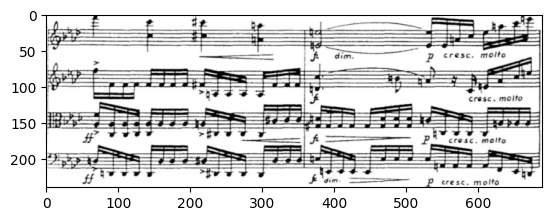

In [11]:
imshow(i)

### Token Pixel Shift Analysis(X-axis)

In [148]:
i = 0
img[...,i:img.shape[-1]-8+i].shape

torch.Size([1, 240, 1366])

In [149]:
shifted_imgs = []

for i in range(8):
  shifted_imgs.append(img[...,i*2:img.shape[-1]-15+i*2])

In [150]:
shifted_imgs = torch.stack(shifted_imgs)
shifted_imgs.shape

torch.Size([8, 1, 240, 1359])

In [151]:
shifted_quant, shifted_emb_loss, shifted_info = unfit_model.encode(shifted_imgs.cuda())

In [152]:
unflattended_out = shifted_info[2].view(shifted_quant.shape[0],shifted_quant.shape[-2],shifted_quant.shape[-1])
unflattended_out.shape

torch.Size([8, 15, 84])

In [153]:
unflattended_out[0]

tensor([[ 1639,  2113,  2832,  ...,  6778,  2336,  5795],
        [14386,  5195,  6072,  ..., 11573, 15144, 12628],
        [11866, 10838,   312,  ...,   832, 11644, 12713],
        ...,
        [15323,  7339, 10051,  ...,  5950,  4511,  6231],
        [ 3980,  1165,  8047,  ...,  2707,  2113,  1016],
        [14103,  5985,  5276,  ...,  7710,  7710,  5841]], device='cuda:0')

In [154]:
unflattended_out[1]

tensor([[ 1733,  2113,  2832,  ...,  3104,  5433,  5820],
        [13836,  3516,  5530,  ..., 10214, 14021, 10691],
        [14099, 12175,  1291,  ...,  6839, 10384, 10768],
        ...,
        [15030,  3651, 10446,  ...,  5950,  6582,  6231],
        [ 2222,   282, 10200,  ...,  2707,  2113,  1016],
        [11421,  8538,  6502,  ...,  7710,  7710,  5841]], device='cuda:0')

In [155]:
unflattended_out[2]

tensor([[  356,  2113,  2832,  ...,  2229,  4862,  3153],
        [12833,    59,  4743,  ...,  8537, 12104,  6577],
        [14323, 11337,  1632,  ..., 10943, 11721, 13090],
        ...,
        [15060,  7945, 11099,  ...,  4626,  6582,  6231],
        [  449,   563,  8259,  ...,  2707,  2113,  2334],
        [11750,  2415,  5630,  ...,  7710,  7710,  5841]], device='cuda:0')

In [156]:
unflattended_out[3]

tensor([[ 1346,  3723,  4047,  ...,  2229,  5749, 10067],
        [11267,  1708,  4743,  ...,  6243, 11728,   503],
        [14405, 10373,   632,  ..., 12311, 10119, 13256],
        ...,
        [14745, 10927, 13231,  ...,  4626,  6582,  6231],
        [  475,  1817,  8650,  ...,  2707,  2113,  2334],
        [12434,  4754,  4288,  ...,  7710,  7710,  5841]], device='cuda:0')

In [157]:
unflattended_out[4]

tensor([[  397,  2113,  4047,  ...,   218,   135, 10078],
        [11852,  1845,  4793,  ...,  7923, 10920,  2090],
        [14670,  7283,  4764,  ..., 13456, 12781, 14097],
        ...,
        [13343, 12250, 13892,  ...,  4511,  6582,  6231],
        [ 2490,  7960,  8027,  ...,  2113,  2113,  2334],
        [13878,  2832,  8682,  ...,  7710,  7710,  5841]], device='cuda:0')

In [158]:
unflattended_out[5]

tensor([[  449,  2113,  4047,  ...,  1637,  1097,  8504],
        [10360,  3524,  4793,  ...,  9378, 11795,  7284],
        [12971,  7643,  3386,  ..., 13599, 14855, 13219],
        ...,
        [13387,  7549, 14737,  ...,  4511,  6582,  4626],
        [  631,  2263,  8869,  ...,  2113,  2113,  2334],
        [12812,  2832,  8682,  ...,  7710,  7710,  5841]], device='cuda:0')

In [159]:
shifted_decoded = unfit_model.decode_code(shifted_info[2].view(shifted_quant.shape[0],shifted_quant.shape[-2],shifted_quant.shape[-1]))
shifted_decoded.shape

torch.Size([8, 1, 240, 1344])

0


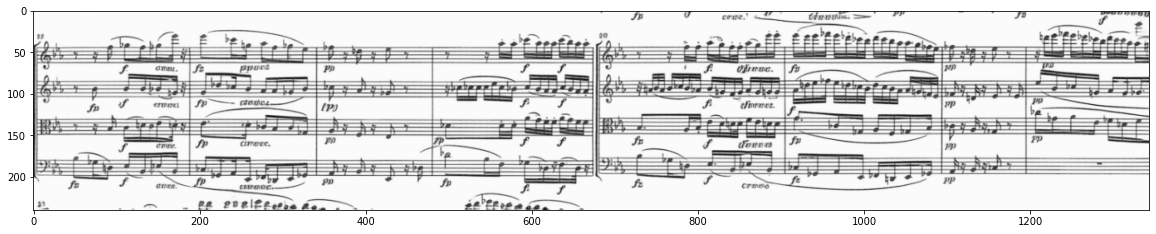

1


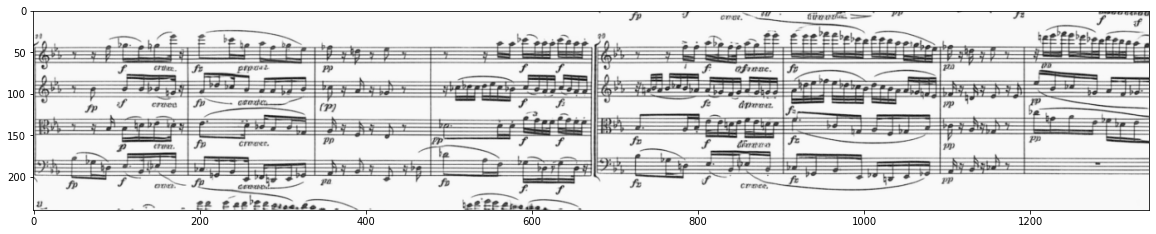

2


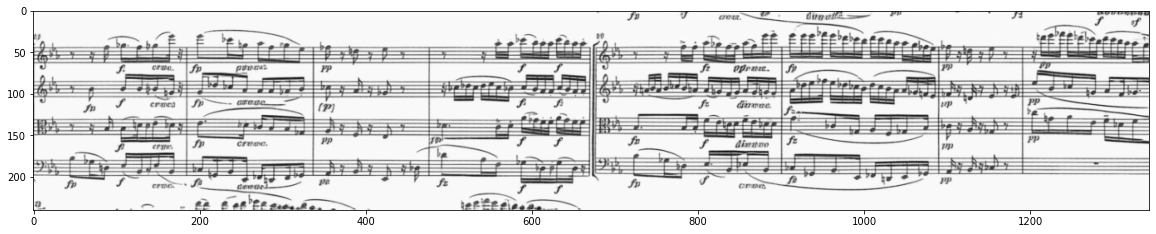

3


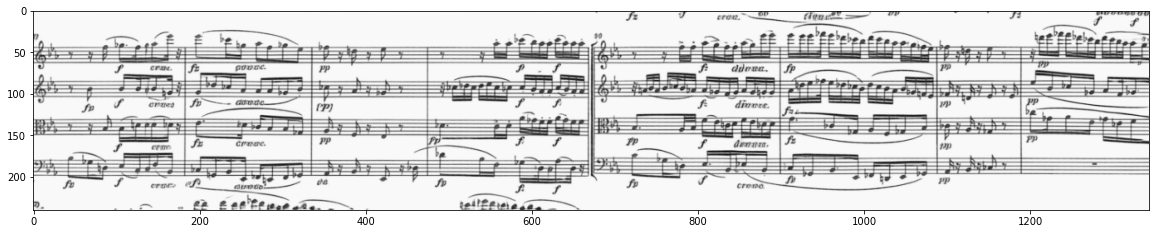

4


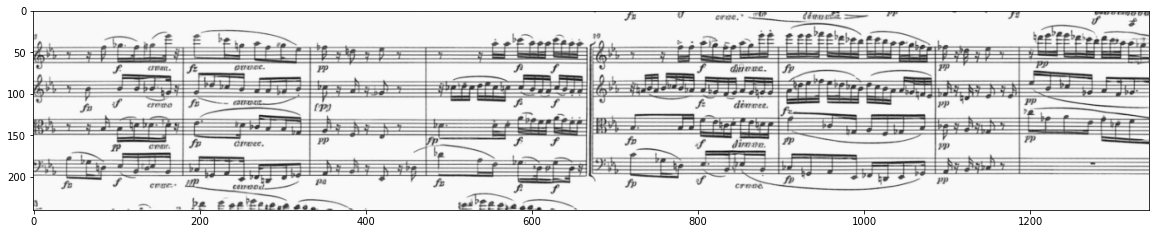

5


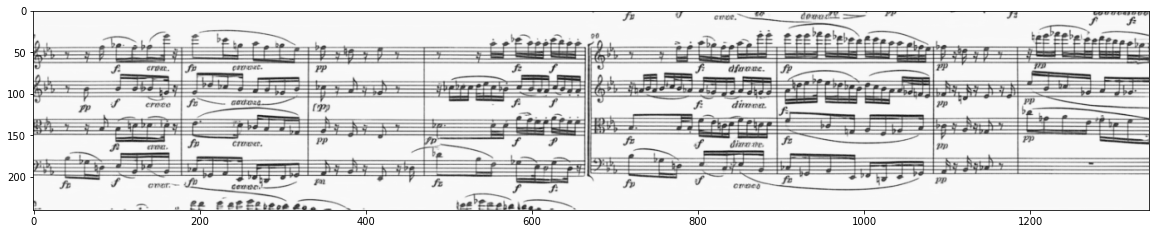

6


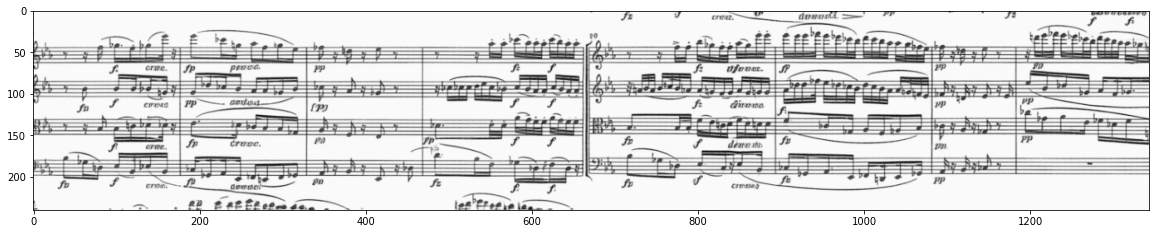

7


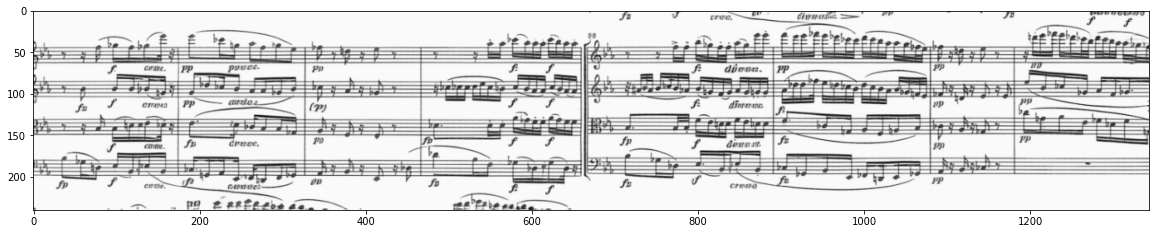

In [160]:
for i in range(8):
  print(i)
  plt.figure(figsize=(20,10), dpi=72)
  imshow(shifted_decoded[i].squeeze().cpu())

### Token Pixel Shift Analysis(Y-axis)

In [161]:
img.shape

torch.Size([1, 240, 1374])

In [162]:
i = 0
img[:,i:img.shape[-2]-4+i].shape

torch.Size([1, 236, 1374])

In [163]:
shifted_imgs = []

for i in range(5):
  shifted_imgs.append(img[:,i:img.shape[-2]-4+i])

In [164]:
shifted_imgs = []

for i in range(5):
  padded_img = torch.nn.functional.pad(img[:, i:img.shape[-2]-4+i], (0, 0, 4-i, i), mode='replicate')
  shifted_imgs.append(padded_img)


In [165]:
shifted_imgs = torch.stack(shifted_imgs)
shifted_imgs.shape

torch.Size([5, 1, 240, 1374])

In [166]:
shifted_quant, shifted_emb_loss, shifted_info = unfit_model.encode(shifted_imgs.cuda())

In [167]:
unflattended_out = shifted_info[2].view(shifted_quant.shape[0],shifted_quant.shape[-2],shifted_quant.shape[-1])
unflattended_out.shape

torch.Size([5, 15, 85])

In [168]:
unflattended_out[0]

tensor([[ 1193,  4047,  2026,  ...,  5057,  4136,  7011],
        [ 8275,  5195,  6968,  ..., 12932,  8026, 15098],
        [13282,  8613,  3708,  ..., 13545, 11533, 14187],
        ...,
        [13166, 12141, 13118,  ..., 12070, 12124, 10953],
        [ 2542,   644,  7959,  ...,  1517,  1495,  1406],
        [12608,  6642,  9634,  ...,  9285,  9028,  8171]], device='cuda:0')

In [169]:
unflattended_out[1]

tensor([[  397,  4047,  2026,  ...,  4298,  2027,  3211],
        [11168,  5195,  4848,  ..., 14684, 10861,  3470],
        [11677,  9797,  1956,  ..., 12990, 13143, 13098],
        ...,
        [14207, 11244, 12454,  ..., 11113, 12185, 10885],
        [ 2236,   282,  8569,  ...,  2140,  2140,  1406],
        [ 5019,  8664,  5655,  ...,  9028,  9028,  6869]], device='cuda:0')

In [170]:
unflattended_out[2]

tensor([[ 1639,  2113,  2832,  ...,  1674,  6893,  1463],
        [14386,  5195,  6072,  ..., 15371, 13900,  2898],
        [11866, 10838,   312,  ..., 11644, 14424, 12708],
        ...,
        [15323,  7339, 10051,  ...,  6582,  6231,  5107],
        [ 3980,  1165,  8047,  ...,  2113,  2113,   987],
        [13265,  7975,  5276,  ...,  7710,  7710,  6869]], device='cuda:0')

In [171]:
unflattended_out[3]

tensor([[ 1733,  2113,  2832,  ...,  5310,  6191,  6223],
        [15139,  6058,  3750,  ..., 14433, 14430,  8269],
        [13962, 12851,  6895,  ..., 10215, 14711,  9807],
        ...,
        [15392,  4375,  8981,  ...,  1689,  5424,  4126],
        [ 4951,    74,  2197,  ...,  1477,  3679,  4924],
        [12093,  8283,  6598,  ...,  7710,  7710,  7553]], device='cuda:0')

In [172]:
unflattended_out[4]

tensor([[  525,  2113,  4286,  ...,  7903,  6245,  1100],
        [15502,  5913,  3279,  ..., 15043, 15571, 10976],
        [13532, 15156,  9755,  ...,  9250, 14185, 11038],
        ...,
        [14867,  6060, 11542,  ...,  2530,  3565,  5327],
        [ 8203,  8086,  4005,  ...,  3238,  3238,  1033],
        [12064,  4182,  4415,  ...,  7710,  7710,  7553]], device='cuda:0')

In [173]:
shifted_decoded = unfit_model.decode_code(shifted_info[2].view(shifted_quant.shape[0],shifted_quant.shape[-2],shifted_quant.shape[-1]))
shifted_decoded.shape

torch.Size([5, 1, 240, 1360])

0


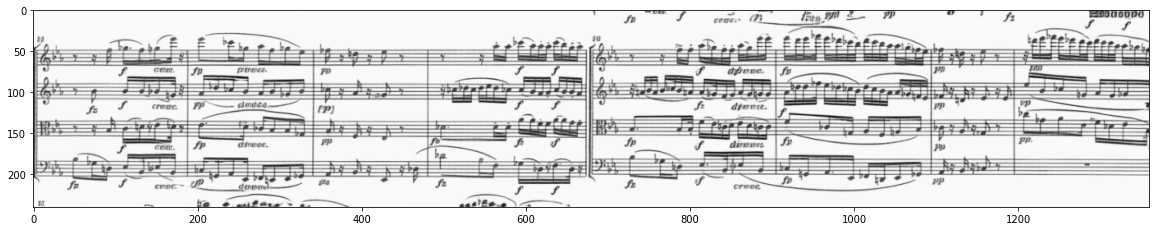

1


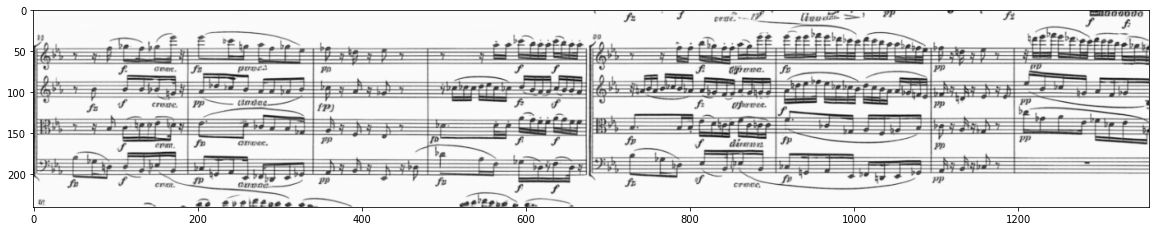

2


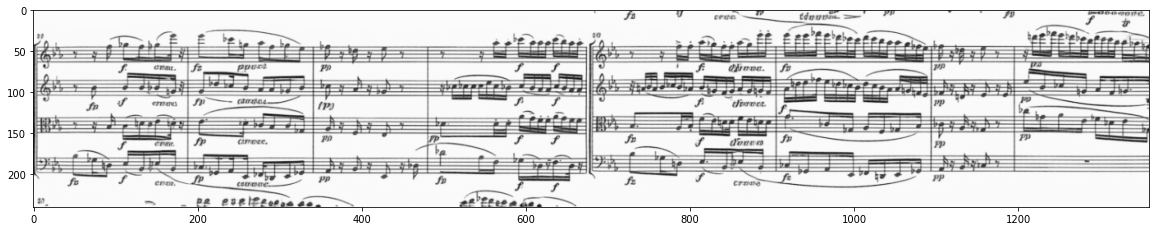

3


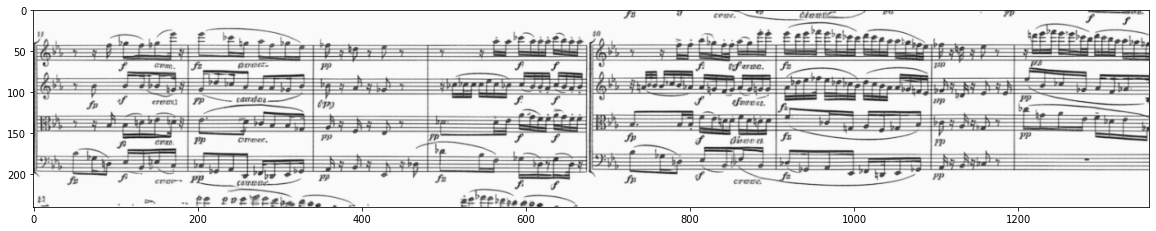

4


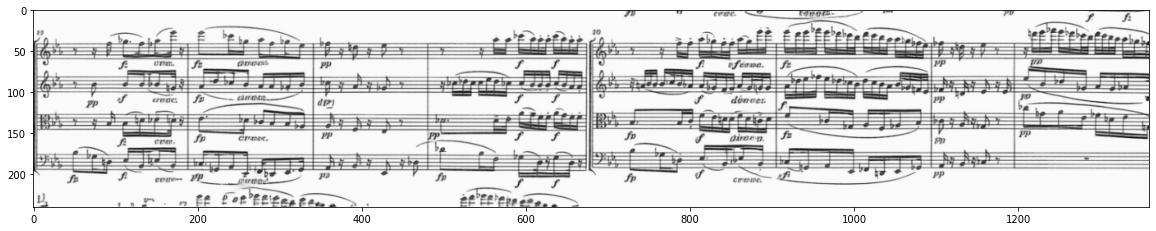

In [174]:
for i in range(5):
  print(i)
  plt.figure(figsize=(20,10), dpi=72)
  imshow(shifted_decoded[i].squeeze().cpu())

### Token Pixel Shift Analysis (X-Y axis)

In [17]:
img.shape

torch.Size([1, 240, 1767])

In [18]:
x_y_shifted_imgs = []

for i in range(16):
  x_shifted_img = img[...,i:img.shape[-1]-15+i]
  y_shifted_imgs = []
  for j in range(4):
    y_shifted_imgs.append(torch.nn.functional.pad(x_shifted_img[:, j:x_shifted_img.shape[-2]-4+j], (0, 0, 4-j, j), mode='replicate'))
  y_shifted_imgs = torch.stack(y_shifted_imgs)
  shifted_quant, shifted_emb_loss, shifted_info = unfit_model.encode(y_shifted_imgs.cuda())
  unflattended_out = shifted_info[2].view(shifted_quant.shape[0],shifted_quant.shape[-2],shifted_quant.shape[-1])
  x_y_shifted_imgs.append(unflattended_out)
x_y_shifted_imgs = torch.stack(x_y_shifted_imgs)
x_y_shifted_imgs.shape

torch.Size([16, 4, 15, 109])

In [14]:
x_y_shifted_imgs.flatten(0,1)[2] == x_y_shifted_imgs[0,2]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [15]:
# x_y_shifted_imgs = []

# for i in range(16):
#   x_shifted_img = img[...,i:img.shape[-1]-15+i]
#   for j in range(4):
#     x_y_shifted_imgs.append(torch.nn.functional.pad(img[:, j:img.shape[-2]-4+j], (0, 0, 4-j, j), mode='replicate'))

In [16]:
len(x_y_shifted_imgs)

64

In [17]:
x_y_shifted_imgs = torch.stack(x_y_shifted_imgs)

In [ ]:
shifted_quant, shifted_emb_loss, shifted_info = unfit_model.encode(x_y_shifted_imgs.cuda())

In [195]:
unflattended_out = shifted_info[2].view(shifted_quant.shape[0],shifted_quant.shape[-2],shifted_quant.shape[-1])
unflattended_out.shape

torch.Size([5, 15, 85])

In [196]:
shifted_decoded = unfit_model.decode_code(shifted_info[2].view(shifted_quant.shape[0],shifted_quant.shape[-2],shifted_quant.shape[-1]))
shifted_decoded.shape

torch.Size([5, 1, 240, 1360])

0


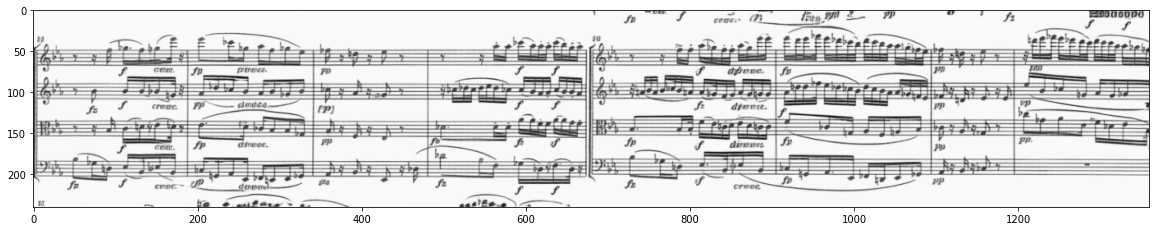

1


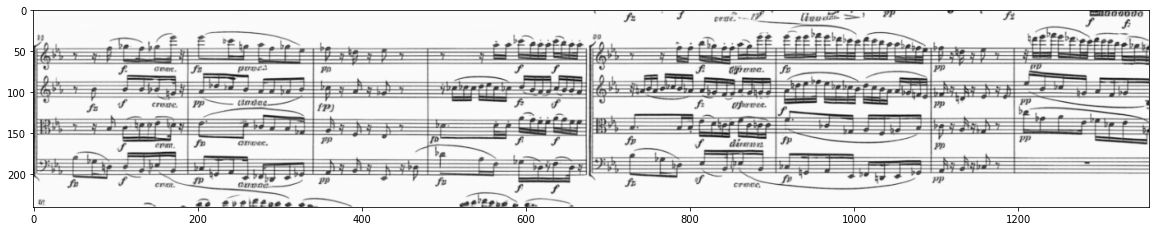

2


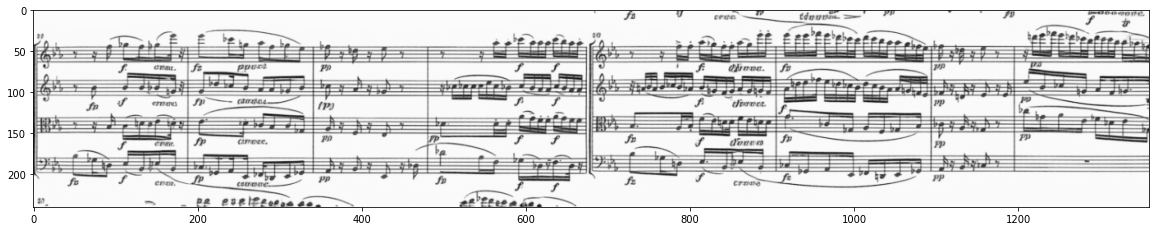

3


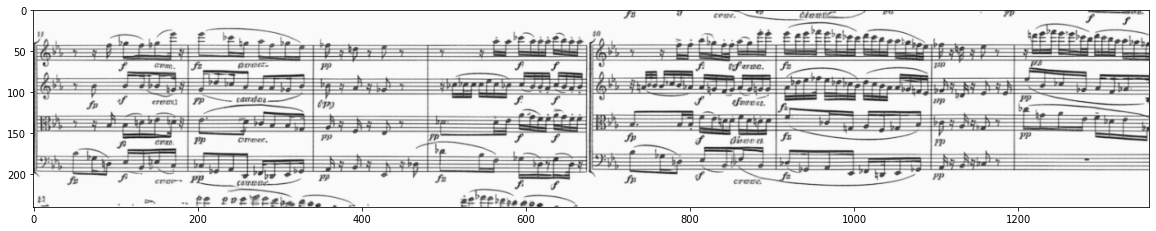

4


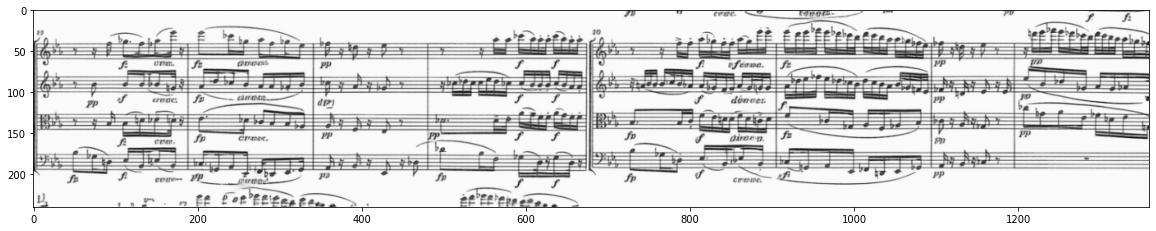

5


IndexError: index 5 is out of bounds for dimension 0 with size 5

<Figure size 1440x720 with 0 Axes>

In [199]:
for i in range(64):
  print(i)
  plt.figure(figsize=(20,10), dpi=72)
  imshow(shifted_decoded[i].squeeze().cpu())